In [1]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d as g_filter
from astropy import units as u
import matplotlib.pyplot as plt
import pandas as pd
import sys
# sys.path.insert(0, "..")
import tools.tools as tools
from tools.file_finder import find_file

In [40]:
# root = r"Z:\OPTODOCS\1Leo\L_240521/"
# root = "./"
# root2 = "../../../OPTOSYNC/Tweezers1/"

date1 = "210524"
date2 = "210609"
date3 = "210525"
date4 = "210610"
date5 = "210611"
rabi_files = [
    find_file("NV", 2, date1, True), find_file("NV", 3, date1, True),
    find_file("NV", 4, date1, True), find_file("NV", 5, date1, True),
    find_file("NV", 6, date1, True), find_file("NV", 8, date1, True),
    find_file("NV", 9, date1, True), find_file("NV", 1, date2, True),
    find_file("NV", 5, date2, True), find_file("NV", 3, date2, True),
    # find_file("NV", 7, date2, True), 
    find_file("NV", 9, date2, True),
    find_file("NV", 9, date3, True), find_file("NV", 4, date3, True),
    find_file("NV", 6, date3, True), 
    # find_file("NV", 2, "210602", True),
    # find_file("NV", 1, "210602", True), find_file("NV", 3, "210602", True),
    find_file("NV", 16, date2, True), find_file("NV", 17, date2, True),
    find_file("NV", 18, date2, True), find_file("NV", 19, date2, True),
    find_file("NV", 20, date2, True),
    find_file("NV", 24, date4, True), find_file("NV", 25, date4, True),
    find_file("NV", 26, date4, True), find_file("NV", 29, date4, True), 
    find_file("NV", 30, date4, True),
    find_file("NV", 1, date5, True), find_file("NV", 2, date5, True),
    find_file("NV", 4, date5, True), find_file("NV", 5, date5, True),
    find_file("NV", 6, date5, True)

][::-1]

rabi_plot_files = [
    find_file("NV", 1, "210609"), find_file("NV", 3, "210609"),
    find_file("NV", 5, "210609"), find_file("NV", 2, "210524"),
    find_file("NV",  2, "210524"), find_file("NV",  3, "210524"), 
    find_file("NV",  4, "210524"), find_file("NV", 4, "210525"),
    find_file("NV", 5, "210524"), find_file("NV", 6, "210524"), #find_file("NV", 7, "210524"), 
    find_file("NV", 8, "210524"), find_file("NV", 9, "210524"), 
    find_file("NV", 6, "210525"), find_file("NV", 9, "210525"),
    # find_file("NV", 1, "210602"), find_file("NV", 2, "210602"),
    # find_file("NV", 3, "210602"), find_file("NV", 4, "210602"),
    find_file("NV", 16, date2), find_file("NV", 17, date2), 
    find_file("NV", 18, date2), find_file("NV", 19, date2),
    find_file("NV", 20, date2),
    find_file("NV", 24, date4), find_file("NV", 25, date4),
    find_file("NV", 26, date4), find_file("NV", 29, date4), 
    find_file("NV", 30, date4),
    find_file("NV", 1, date5), find_file("NV", 2, date5), 
    find_file("NV", 4, date5)
]

rabi_specs = [pd.read_csv(f, skiprows=20, names=['time', 'counts'], delimiter='\t') for f in rabi_files]
rabi_plots = [np.genfromtxt(f, skip_header=20).T for f in rabi_plot_files]

# test_time = np.arange(30000)
# test_signal = np.sin(1e-1*test_time**(0.7))
# m = test_signal > 0.75
# test_signal[m] = 10 + 3e-5 * test_time[m]
# test_signal[~m] = 0.
# plt.plot(test_time, test_signal)
# test_data = pd.DataFrame({"counts": test_signal, "time":test_time})
test_data = pd.read_csv("sim_out.txt", sep=" ", names=("time", "counts"))
rabi_specs = [test_data] + rabi_specs
rabi_files = ["test signal"] + rabi_files

raw_titles = [x[-20:] for x in rabi_files]
proc_titles = [x[-20:] for x in rabi_plot_files]

Caching...Done.Caching...Done.

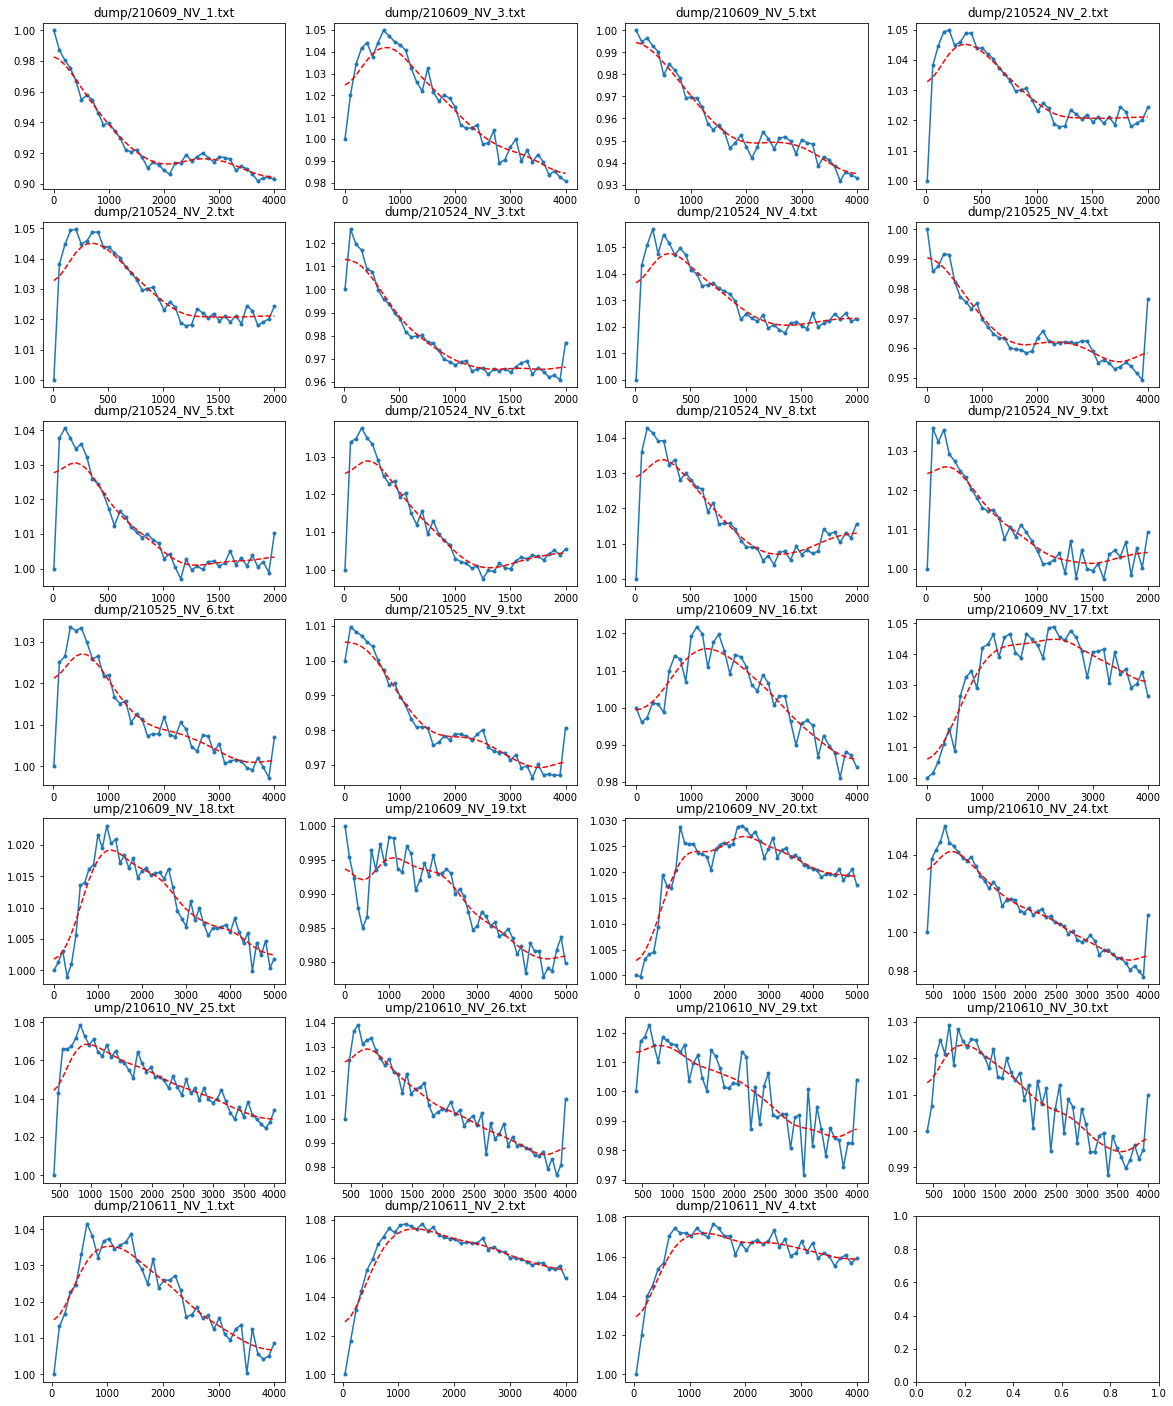

In [41]:
fig = plt.figure(figsize=(20, 25))
tau_axes = [r[0] for r in rabi_plots]

plot_col = 1
n_cols = 4
axes = fig.subplots(
    nrows=(n_cols - 1 + len(rabi_plots)) // n_cols, 
    ncols=n_cols, sharex="none").flatten()
for i, (tau, plot) in enumerate(zip(tau_axes, rabi_plots)):
    ax = axes[i]
    ax.set_title(proc_titles[i])
    data = plot[plot_col]
    z_mask = data != 0.
    smoothed = g_filter(data[z_mask], 3)
    ax.plot(tau[z_mask], data[z_mask], '.-')
    ax.plot(tau[z_mask], smoothed, 'r--')

plt.show()
# plt.plot(*rabi_plots[2][[0,6]])

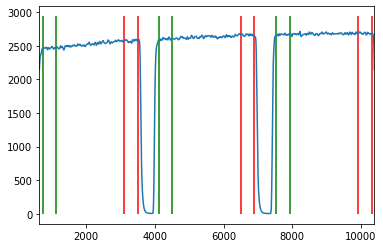

In [42]:
# Remember raw counts files are read in as panda dataframes

# Smooth raw data
for data in rabi_specs:
    data['smooth'] = g_filter(data.counts, sigma=4)

max_counts = np.array([max(data.smooth) for data in rabi_specs])

COUNTS_THRESHOLD = 0.8 # * the max number of counts in any bin

ris_fals = [
    tools.get_rise_falls(np.array(data.smooth), thresh) 
    for data, thresh in zip(rabi_specs, COUNTS_THRESHOLD*max_counts)
]
rises = [rf[0] for rf in ris_fals]
falls = [rf[1] for rf in ris_fals]

rise_ts = [np.array(data.time[r]) for data, r in zip(rabi_specs, rises)]
fall_ts = [np.array(data.time[f]) for data, f in zip(rabi_specs, falls)]

################################################################
integration_width_ns = 400 # ns
# TODO FIx this make it dependent on step size
dt = np.array([spec.time[1] - spec.time[0] for spec in rabi_specs])
integration_width = (integration_width_ns // dt).astype(int)
# integration_width

forwards_shift = 30
backwards_shift = -20
################################################################

def get_readout_start_and_ends(rise_ts, fall_ts):
    """ Assumes that the first rise and fall are always 
    from the same readout pulse. """
    fin_len = min(len(rise_ts), len(fall_ts))
    result = np.zeros((fin_len, 2))
    result[:,0] = rise_ts[:fin_len]
    result[:,1] = fall_ts[:fin_len]
    return result

f = True
start_ends = [] # pairs of pulse start and end times
start_ends_idx = []
for i,(spec, s_rises, s_falls, s_rise_ts, s_fall_ts) in enumerate(zip(
        rabi_specs, rises, falls, rise_ts, fall_ts)):
    start_end = get_readout_start_and_ends(s_rise_ts, s_fall_ts)
    start_end_idx = get_readout_start_and_ends(s_rises, s_falls)
    start_ends.append(start_end)
    start_ends_idx.append(start_end_idx)
if f:
    plt.plot(spec.time, spec.smooth)
    top = max(spec.counts)
    plt.vlines(forwards_shift*dt[i] + s_rise_ts, 0, top, "green")
    plt.vlines(forwards_shift*dt[i] + s_rise_ts + dt[i]*integration_width[i], 0, top, "green")
    plt.vlines(backwards_shift*dt[i] + s_fall_ts, 0, top, "red")
    plt.vlines(backwards_shift*dt[i] + s_fall_ts - dt[i]*integration_width[i], 0, top, "red")
    plt.xlim(s_rise_ts[0], s_fall_ts[2])
    f = False


# readout_counts = np.array(data.counts)[[pulses[:, 0]: pulses[:, 0] + integration_width]] 
take_previous_fall = True # If false, use the fall of the same pulse as the reference signal
spec_tau_axes = []
PL_reads = []
PL_refs = []
for (spec, start_end, start_end_idx, int_width) in zip(
        rabi_specs, start_ends, start_ends_idx, integration_width):
    forward_t = np.arange(int_width)
    x = take_previous_fall * 1 # Scan the arrays in a fashion that depends on this setting
    forward = np.tile(forward_t, (len(start_end_idx)-x, 1)) 
    backward = -forward
    forward += forwards_shift
    backward += backwards_shift
    reads = (forward + start_end_idx[x:, [0]]).astype(int)
    refs = (backward + start_end_idx[:-x, [1]]).astype(int)

    tau = start_end[1:, 0] - start_end[:-1, 1]
    # if not take_previous_fall ignore the first pulse
    reads = reads[1-x:]
    refs  = refs[1-x:]

    arr = np.array(spec.counts)
    reads = np.sum(arr[reads], axis=-1)
    refs  = np.sum(arr[refs], axis=-1)

    spec_tau_axes.append(tau)
    PL_reads.append(reads)
    PL_refs.append(refs)





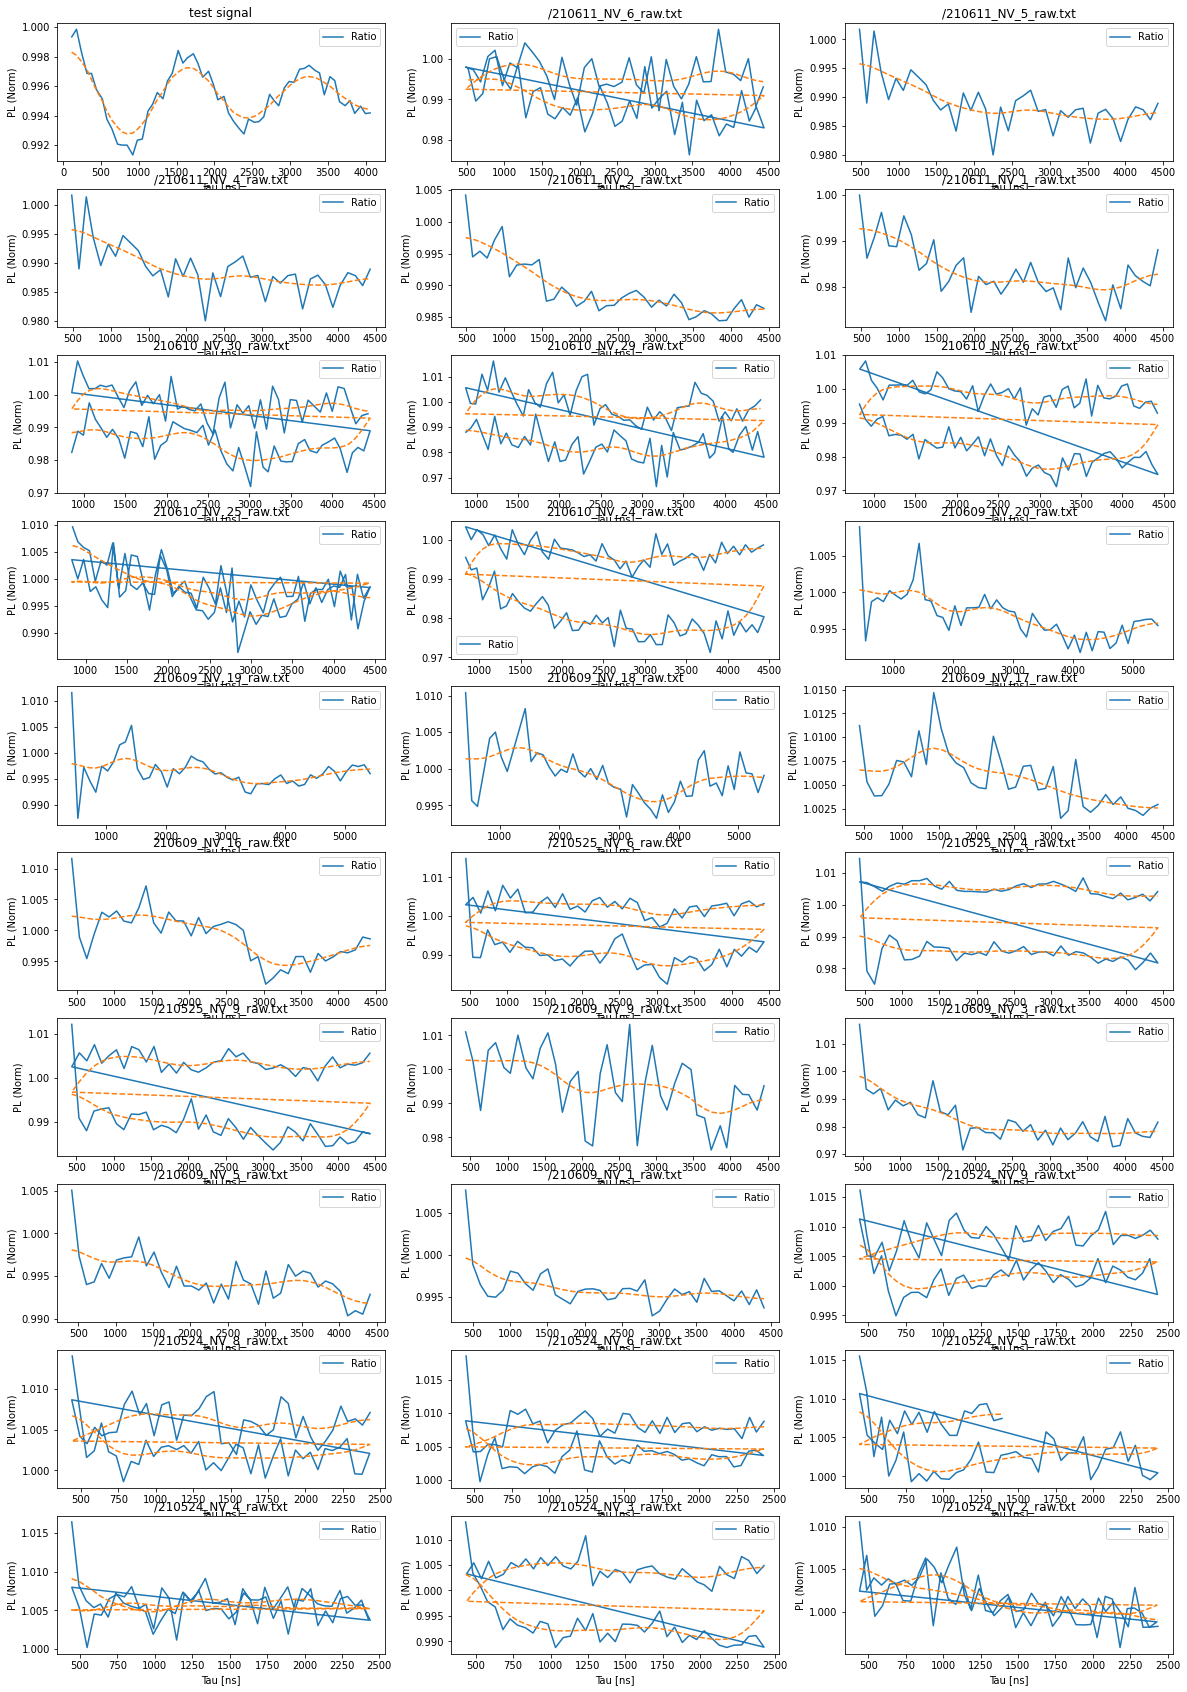

In [43]:

fig = plt.figure(figsize=(20, 30))
n_cols = 3
axes = fig.subplots(
    nrows=(len(rabi_files)+n_cols-1)//n_cols, 
    ncols=n_cols,
    sharex="none").flatten()
for (title, tau, read, ref, ax) in zip(raw_titles, spec_tau_axes, PL_reads, PL_refs, axes):
    ax.set_title(title)
    diff = ref - read
    ratio = read / ref
    diff = diff / max(diff) * ratio[0]
    smoothing_sigma = 3
    smooth_diff = g_filter(diff, smoothing_sigma)
    smooth_ratio = g_filter(ratio, smoothing_sigma)
    smooth_read = g_filter(read, smoothing_sigma)
    smooth_ref = g_filter(ref, smoothing_sigma)
    # ax.plot(tau, diff, ".", label="Diff") 
    ax.plot(tau, ratio, label="Ratio"); ax.plot(tau, smooth_ratio, "--")
    # ax.plot(tau, read, label="PL Read")
    # ax.plot(tau, ref, label="PL Ref")
    ax.set_xlabel("Tau [ns]")
    ax.set_ylabel("PL (Norm)")
    ax.legend()
    # break
plt.show()


In [198]:
start_ends[0][0]

array([525., 888.])